# Latent Variable Models : applications and examples

In [1]:
%load_ext lab_black
# from jyquickhelper import add_notebook_menu
# add_notebook_menu()

## Reminder & warm-up

An EM algorithm is an iterative optimization of the following variational lower bound $\mathcal{L}(\theta, q) = \int q(T) \log\frac{p(X, T|\theta)}{q(T)}dT$.

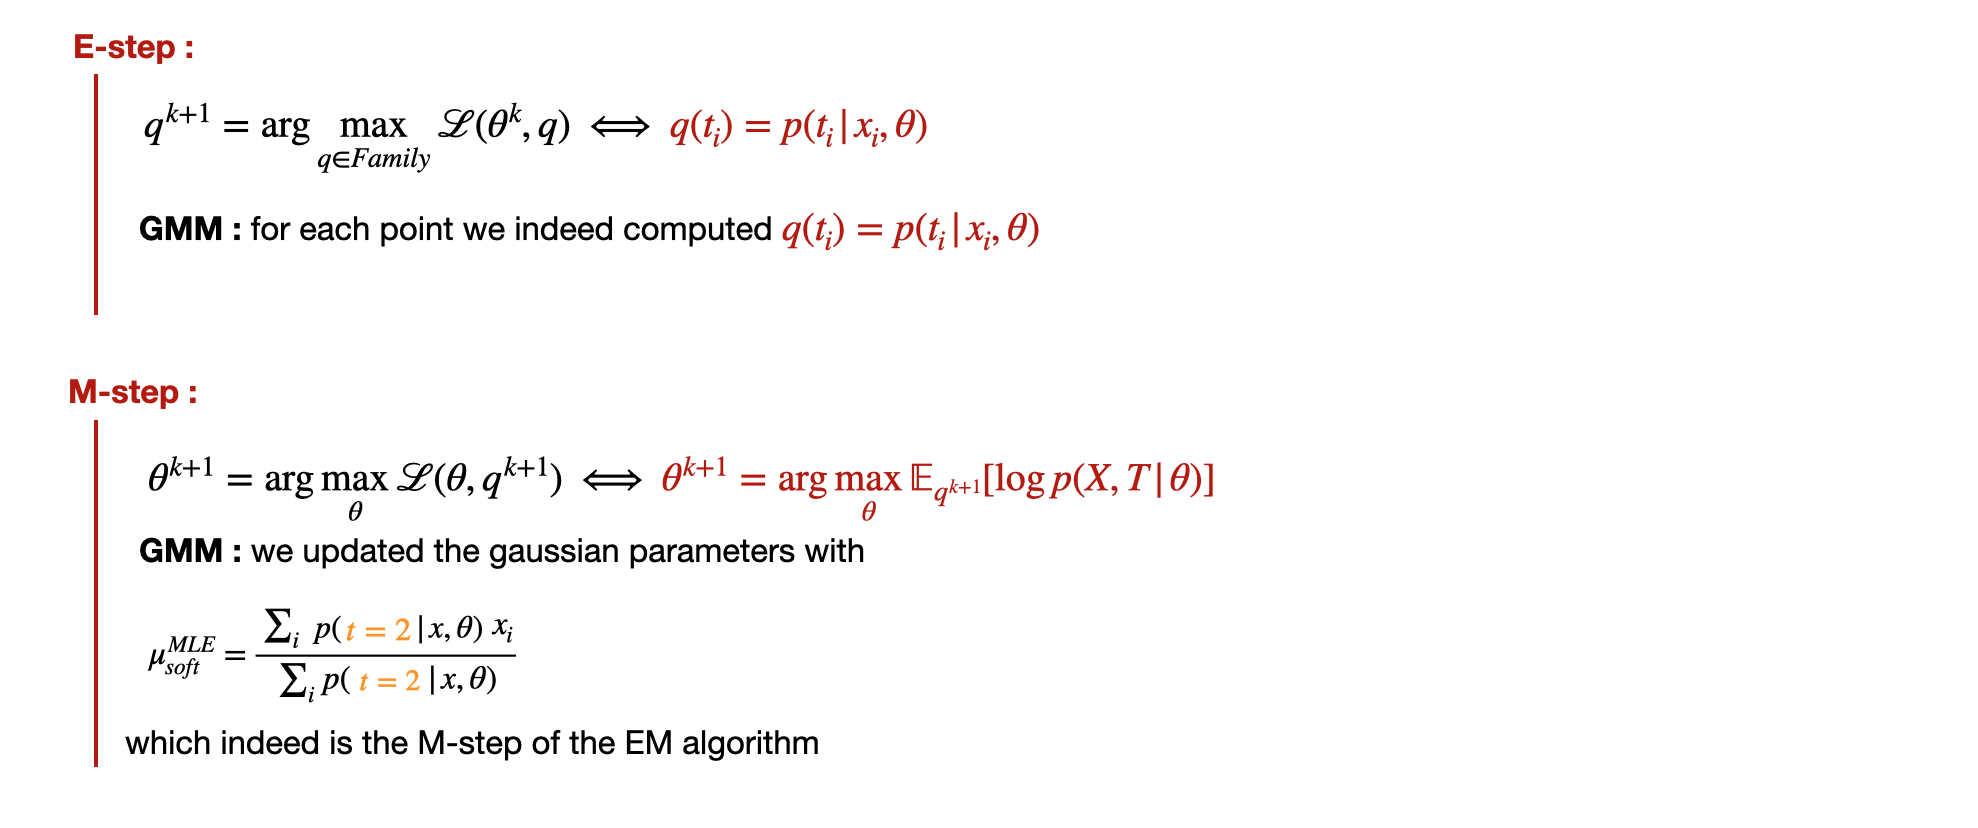

In [2]:
from sklearn.datasets import load_breast_cancer
import numpy as np

data = load_breast_cancer()
X = data["data"]
y = data["target"]

**Question 1 :** Give the shape of X and y.

In [3]:
X.shape, y.shape

((569, 30), (569,))

**Question 2 :** Plot the first two dimension of X and color the instances according to its class y

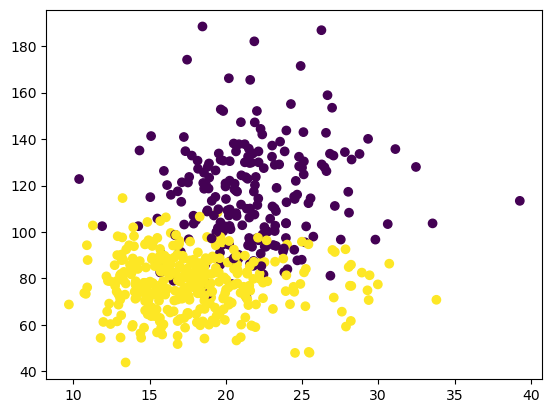

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(X[:, 1], X[:, 2], c=y)
plt.show()

For the sake of the following section, let us discard completely the class y.

## 1. Clustering : a probabilistic point of view with k-means

We recall that k-means is a clustering algorithm which has the following pseudo-algorotihm :

**Input :** number of clusters $K$, dataset $X$

**Output :** the clusters

1. Randomly initialize the parameters $\theta = \{centroid_1, \dots, centroid_K\}$

2. Repeat until convergence :
    - For each instance $x$, compute the closest centroid :
    $$
    k_i = \arg\min_{k} \lVert x_i - centroid_k \lVert^2
    $$
    
    - Update the centroids :
    $$
    centroid_k = \frac{\sum_{i:k_i=k} x_i}{|{i:k_i=k}|}
    $$

**Question 3 :** Define the function `kmeans_naive` and test it out on $X$ with $K=3$. Plot the first two dimensions of $X$ and color the instances according to its cluster

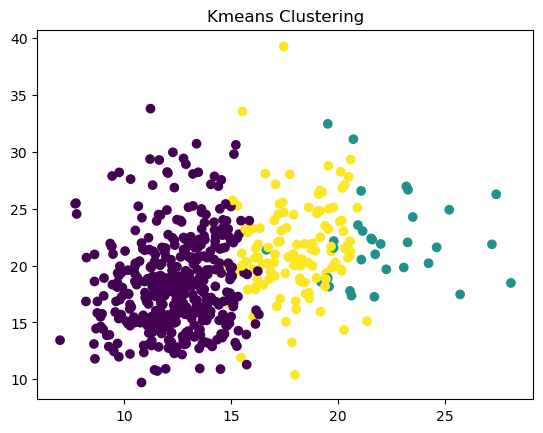

In [5]:
np.random.seed(42)


def kmeans_naive(X, K):
    m, n = X.shape
    centroids = X[np.random.choice(m, K, replace=False)]
    while True:
        cluster = get_cluster(X, centroids)
        new_centroids = np.array([X[cluster == k].mean(axis=0) for k in range(K)])
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids
    return cluster, centroids


def get_cluster(X, centroids):
    dist_ls = []
    for x in X:
        dists = [np.linalg.norm(x - c) ** 2 for c in centroids]
        closest_centroid = np.argmin(dists)
        dist_ls.append(closest_centroid)
    return np.array(dist_ls)


cluster, centroids = kmeans_naive(X, 3)
plt.scatter(X[:, 0], X[:, 1], c=cluster)
plt.title("Kmeans Clustering")
plt.show()

**Question 4 :** Define the function `GMM_hard` (p.24) which fit a Gaussian Mixture Model (with hard clustering). We assume two things here 
- $\Sigma = I_d$ is **known** and is identical ;
- $\pi_k$ is known and is uniform.

In [6]:
import numpy as np
from scipy.stats import multivariate_normal


def GMM_hard(X, K, tol=1e-5):
    m, n = X.shape
    means = X[np.random.choice(m, K, replace=False)]
    converged = False
    while not converged:
        rv = np.array(
            [multivariate_normal(mean=mu, cov=np.eye(n)).pdf(X) for mu in means]
        )
        clusters = np.argmax(rv.T, axis=1)
        means_new = np.array([X[clusters == k].mean(axis=0) for k in range(K)])
        if np.max(np.linalg.norm(means_new - means, axis=1)) < tol:
            converged = True
        else:
            means = means_new

    return clusters, means

**Question 5 :** What do we see ?

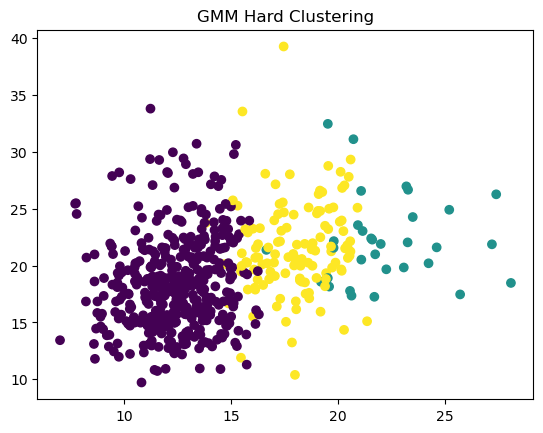

In [7]:
clusters, means = GMM_hard(X, 3)

plt.scatter(X[:, 0], X[:, 1], c=cluster)
plt.title("GMM Hard Clustering")
plt.show()

**Question 5 :** Redefine `GMM_hard` and let us take assume that $\Sigma_k$ and $\pi_k$ are no longer known. Plot the results

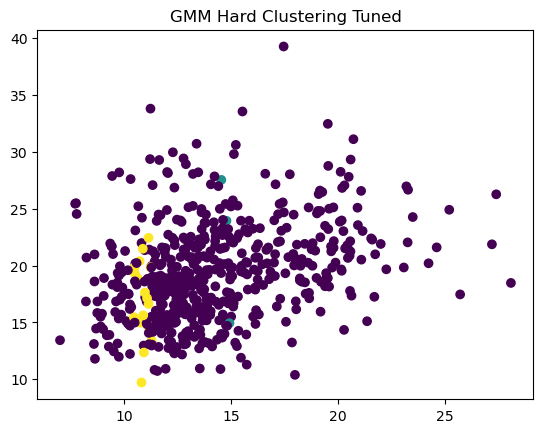

In [8]:
from scipy.stats import multivariate_normal


def GMM_hard(X, K, tol=1e-5, reg_covar=1e-6):
    m, n = X.shape
    means = X[np.random.choice(m, K, replace=False)]
    covariances = np.array([np.eye(n) for _ in range(K)])
    pi = np.ones(K) / K
    converged = False

    while not converged:
        # E-step
        rv = np.array(
            [
                pi[k]
                * multivariate_normal(
                    mean=means[k], cov=covariances[k], allow_singular=True
                ).pdf(X)
                for k in range(K)
            ]
        )
        clusters = np.argmax(rv.T, axis=1)

        # M-step
        new_means = np.array([X[clusters == k].mean(axis=0) for k in range(K)])
        new_covariances = np.array(
            [
                (X[clusters == k] - new_means[k]).T.dot(X[clusters == k] - new_means[k])
                / (X[clusters == k].shape[0])
                + reg_covar * np.eye(n)
                for k in range(K)
            ]
        )
        new_pi = np.array([np.sum(clusters == k) / m for k in range(K)])

        if np.max(np.linalg.norm(new_means - means, axis=1)) < tol:
            converged = True
        else:
            means = new_means
            covariances = new_covariances
            pi = new_pi

    return clusters, means, covariances, pi


clusters_hard, means_hard, covariances_hard, pi_hard = GMM_hard(X, 3)
plt.scatter(X[:, 0], X[:, 1], c=clusters_hard)
plt.title("GMM Hard Clustering Tuned")
plt.show()

**[OPTIONAL] Question 6 :** Define `GMM_soft` which fit a GMM with soft clustering. Plot the results

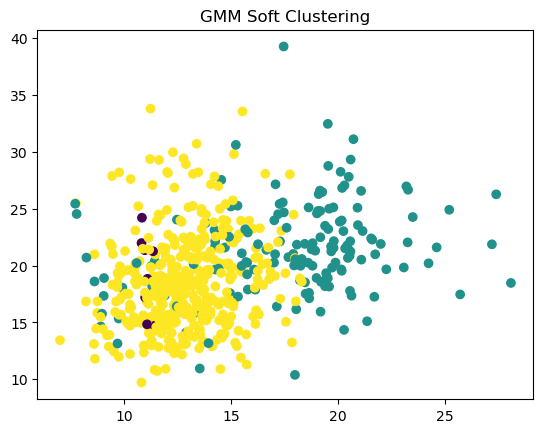

In [9]:
import numpy as np
from scipy.stats import multivariate_normal


def GMM_soft(X, K, tol=1e-5, reg_covar=1e-6):
    m, n = X.shape
    means = X[np.random.choice(m, K, replace=False)]
    covariances = np.array([np.eye(n) for _ in range(K)])
    pi = np.ones(K) / K
    responsibilities = np.zeros((m, K))
    converged = False

    while not converged:
        # E-step
        for k in range(K):
            try:
                rv = multivariate_normal(
                    mean=means[k],
                    cov=covariances[k] + reg_covar * np.eye(n),
                    allow_singular=True,
                )
                responsibilities[:, k] = pi[k] * rv.pdf(X)
            except np.linalg.LinAlgError:
                responsibilities[:, k] = 0

        total_responsibilities = responsibilities.sum(axis=1, keepdims=True)
        # Handle the case where total responsibilities are zero to avoid division by zero
        total_responsibilities[total_responsibilities == 0] = 1e-10
        responsibilities = responsibilities / total_responsibilities

        # M-step
        Nk = responsibilities.sum(axis=0)
        new_means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        new_covariances = np.array(
            [
                (
                    np.dot(
                        (responsibilities[:, k] * (X - new_means[k]).T),
                        (X - new_means[k]),
                    )
                    / Nk[k]
                    + reg_covar * np.eye(n)
                )
                for k in range(K)
            ]
        )
        new_pi = Nk / m

        if np.max(np.linalg.norm(new_means - means, axis=1)) < tol:
            converged = True
        else:
            means = new_means
            covariances = new_covariances
            pi = new_pi

    return responsibilities, means, covariances, pi


# Run the refined GMM_soft function
responsibilities, means_soft, covariances_soft, pi_soft = GMM_soft(X, 3)
clusters_soft = np.argmax(responsibilities, axis=1)
plt.scatter(X[:, 0], X[:, 1], c=clusters_soft)
plt.title("GMM Soft Clustering")
plt.show()

## 2. Dimensionality reduction : a probabilistic point of view with PCA

PPCA is a dimensionality reduction technique that is often used when we have some missing values in the dataset. We assume that each latent variable is normally distributed :
$$
t_i \sim \mathcal{N}(0, I_K)
$$

The instance $x$ associated is generated by the following projection :
$$
x_i | t_i \sim \mathcal{N}(W\cdot t_i + b, \Sigma)
$$

**Question 7 :** The PPCA is a general form of PCA. Indeed, we can observe it in marginalizing the latent variable. Find out the distribution of each instance $x | \theta$ (you can use the wikipedia table for the normal conjugacy).

In [10]:
m, n = X.shape
K = 3
W = np.random.randn(n, K)
b = np.zeros(n)
mean = b
Sigma = np.eye(n)
covariance = np.dot(W, W.T) + Sigma * np.eye(len(mean))
instance_dist = multivariate_normal(mean=mean, cov=covariance)
instance_dist.mean, instance_dist.cov

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([[ 1.74724479e+00,  6.47857515e-01, -1.37824074e+00,
          1.25742552e+00,  3.92814317e-01,  5.45693493e-02,
         -3.93290811e-01, -1.08939709e+00, -9.46196131e-03,
          3.17073054e-01, -2.61223455e+00,  3.65030763e-01,
          6.17464659e-01,  7.70007955e-01, -7.55284592e-01,
         -1.54903810e+00, -8.40924693e-01, -1.78977848e-01,
          7.83147645e-01, -2.05154918e+00,  1.95854514e+00,
         -4.11271588e-01,  7.31034516e-01,  1.96710399e+00,
         -6.65563150e-01,  2.41036752e-01, -7.79088768e-01,
          1.28934359e-01, -1.55689667e-01, -6.74291488e-02],
        [ 6.47857515e-01,  7.87725157e+00,  2.26031399e+00,
         -2.00337103e+00,  1.72304714e+00,  4.98488748e+00,
          1.85957347e+00,  2.88147871e+00,  9.91980952e-01,
          1.43423933e+00,  1.31833862e+00,  3.13094656e+00,
          1.68950415e

**Question 8 :** Compute the E-step of the PPCA

In [11]:
def ppca_e_step(X, W, sigma_sq):
    m, n = X.shape
    K = W.shape[1]
    M = np.dot(W.T, W) + sigma_sq * np.eye(K)
    M_inv = np.linalg.inv(M)
    Ez = np.dot(np.dot(M_inv, W.T), X.T).T
    Ezz = sigma_sq * M_inv + np.dot(Ez.T, Ez) / m
    return Ez, Ezz

**Question 9 :** Compute the M-step of the PPCA

In [12]:
def ppca_m_step(X, Ez, Ezz):
    m, n = X.shape
    K = Ez.shape[1]
    W_new = np.dot(np.dot(X.T, Ez), np.linalg.inv(Ezz))
    sigma_sq_new = (np.linalg.norm(X - np.dot(Ez, W_new.T)) ** 2) / (m * n)
    return W_new, sigma_sq_new

**Question 10 :** Do a reduction of dimensionality with PPCA and plot the results with its true labels on a 2D graph

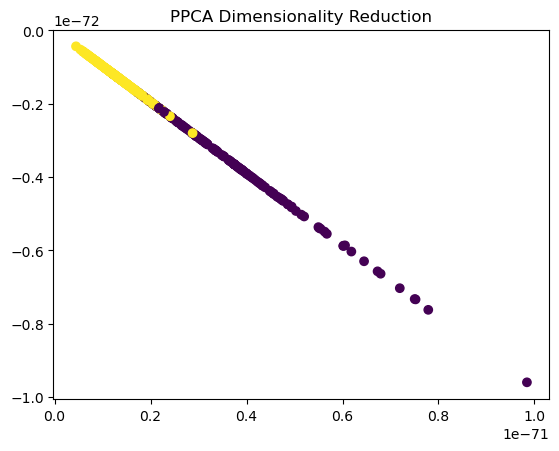

In [13]:
def ppca(X, K, tol=1e-5, max_iter=100):
    m, n = X.shape
    W = np.random.randn(n, K)
    sigma_sq = 1.0
    for _ in range(max_iter):
        Ez, Ezz = ppca_e_step(X, W, sigma_sq)
        W_new, sigma_sq_new = ppca_m_step(X, Ez, Ezz)
        if np.max(np.abs(W_new - W)) < tol:
            break
        W, sigma_sq = W_new, sigma_sq_new
    return W, sigma_sq, Ez


W, sigma_sq, Ez = ppca(X, 2)
plt.scatter(Ez[:, 0], Ez[:, 1], c=y)
plt.title("PPCA Dimensionality Reduction")
plt.show()

### A quick look on the dimensionality reduction with PCA and t-SNE

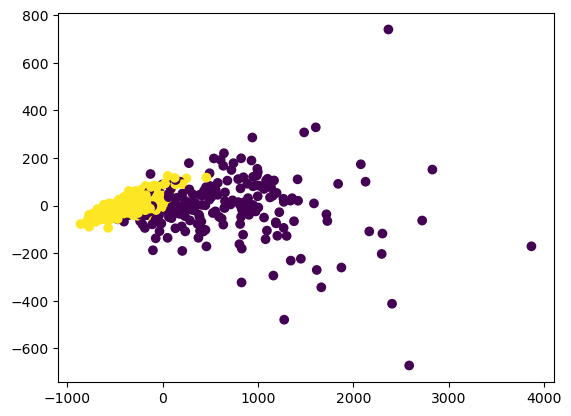

In [14]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

X_reduced = pca.fit_transform(X)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="viridis")

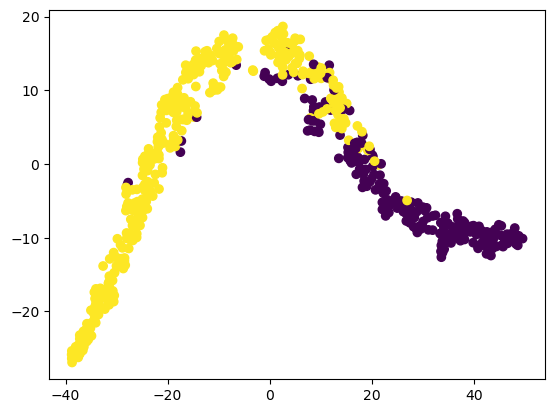

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)

X_embedded = tsne.fit_transform(X)

plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="viridis")